# Notebook 2: Support Vector Machines

Execute the next cell to load the auxiliary functions.

In [1]:
# Read configuration file
import json
import numpy as np
import matplotlib.pyplot as plt
with open('../config/user_config_file.json') as f:
    config_file = json.load(f)

# Import helper functions from src/utils.py ()
import sys
sys.path.append(config_file["utils_location"])
from utils import *

#### STEP 1: Generate data that cannot be linearly separated
The data is generated from the logistic regression model
$$
 \mathbb{P}(Y_i=1) = \Lambda(b+\theta_1 x_{i1}+\theta_2 x_{i2}),
$$
where $\Lambda(x)=\frac{1}{1+\exp(-x)}$ denotes the standard logistic function. We assign the class label +1 to observation $i$ whenever $\mathbb{P}(Y_i+1)\geq 0.5$, and classify the remaining observations as belonging to the class with label -1. By monotinicity of $\Lambda$ it follows that the decision boundary is given by $b+\theta_1 x_{1}+\theta_2 x_{2} = 0$. Whenever $\theta_2\neq 0$, this is the line 
$$
 x_2 = -\frac{\theta_1}{\theta_2} x_1 - \frac{b}{\theta_2}.
$$

The parameters are set as $(b,\theta_1,\theta_2)=(-6, 12, 12)$. The equation for the decision boundary is thus $x_2=-x_1+0.5$. It is displayed in black in the figure below.

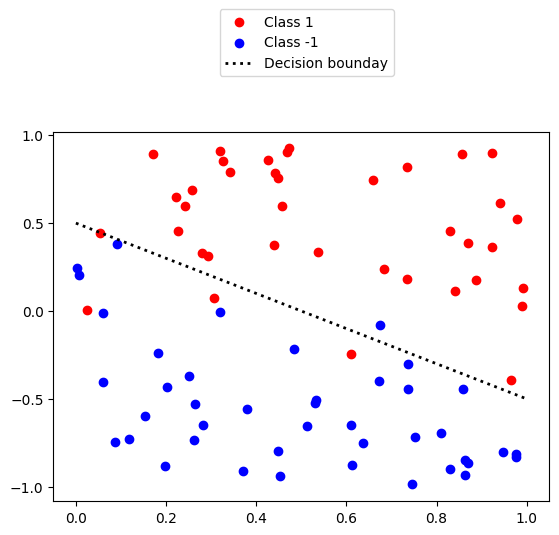

In [2]:
# Generate the data
n = 80
x1, x2, y = generate_logistic_data(-6, 12, 12, n)

# Plot the data
# Class indices
class_a = np.where(y== 1)
class_b = np.where(y == -1)

# Create plot
fig, ax = plt.subplots()
ax.scatter(x1[class_a], x2[class_a], c='r', label="Class 1")
ax.scatter(x1[class_b], x2[class_b],c='b', label="Class -1")
ax.plot([0, 1], [0.5, -0.5], 'k:', label='Decision bounday', linewidth=2)
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax.legend(bbox_to_anchor=(0.7, 1.35))

#### STEP 2: Try to determine separating hyperplane
The cell below tries to solve the quadratic programme (QP) that determines the separating hyperplane. The execution of the cell generates a UserWarning because the primal
does not have a feasible solution. The function $\texttt{determine\_separating\_hyperplane()}$ is imported from $\texttt{utils.py}$. We refer to the notebook $\texttt{Notebook1\_classifying\_Linearly\_Separated\_Data}$ for further details.


In [3]:
try:
    slope, intercept = determine_separating_hyperplane(x1, x2, y)
except:
    print("Failed")

Failed


/Users/hannoreuvers/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/hannoreuvers/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/hannoreuvers/Library/Python/3.9/lib/python/site-packages/qpsolvers/solvers/clarabel_.py:138: UserWarning: Clarabel.rs terminated with status PrimalInfeasible
  warnings.warn(f"Clarabel.rs terminated with status {result.status}")


#### STEP 3: Estimate SVM with QP (PRIMAL)
We determine the primal solution of the _SVM Optimization Problem_, see (12a)-(12c). That is, we construct the QP and determine its solution using the $\texttt{qpsolvers}$ library. Remark 4 in the explainer provides additional information. As outputs, we report $\bm w$, $b$, and a plot of the resulting marginal hyperplane.

It is instructive to change the value of $C$ and see how this affects the marginal hyperplane and the observations that are considered to be outliers (i.e. the observations with nonzero slack variables).

w (primal): [1.18501809 2.80874997]
b (primal): -0.5436693010355096


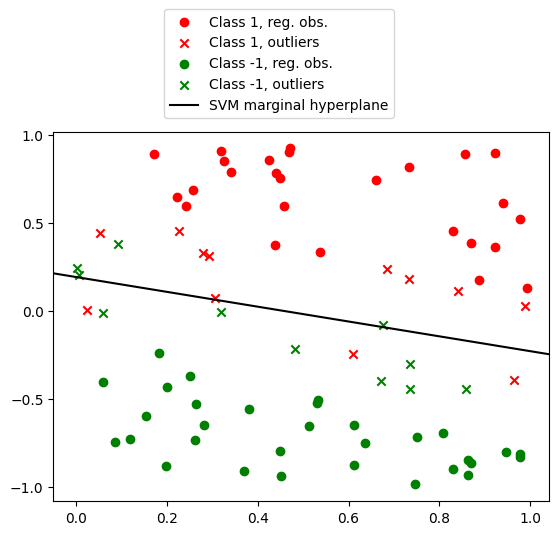

In [4]:
# Hyperparameter
C = 1

# Regressor matrix
X = np.column_stack((x1,x2))
K = X.shape[1]

# Vector of ones
ones = np.full((len(y), 1), 1)

# Matrices for QP
G = np.block([[-y*X, -y,   -np.identity(n)]])
h = -ones
P = np.block([
    [np.identity(K),    np.zeros((K, n+1))],
    [np.zeros((n+1, K)),   np.zeros((n+1,n+1))]])

# Lower bound
vector_neg_infty = -np.reshape(np.repeat(np.inf, K+1), (K+1, 1))
lowerbound = np.vstack((vector_neg_infty, np.zeros((n,1))))

# Linear contribution
q = np.vstack(( np.zeros((K+1, 1)), C*np.ones((n, 1)) ))

# Solve quadratic program
x = solve_qp(P, q, G, h, lb=lowerbound, solver="clarabel")
w_primal = x[:2]
b_primal = x[2]
print(f"w (primal): {w_primal}")
print(f"b (primal): {b_primal}")

# Logic to create plot with interpretation
slack_para = x[3:].flatten()
regulars_class_a = (slack_para<1E-8)*(y.flatten()==1)
outliers_class_a = (slack_para>1E-8)*(y.flatten()==1)
regulars_class_b = (slack_para<1E-8)*(y.flatten()==-1)
outliers_class_b = (slack_para>1E-8)*(y.flatten()==-1)

# Plot figure
slope_SVM = -x[0]/x[1]
intercept_SVM = -x[2]/x[1]
fig, ax = plt.subplots()
ax.scatter(x1[regulars_class_a], x2[regulars_class_a], c='r', marker="o", label="Class 1, reg. obs.")
ax.scatter(x1[outliers_class_a], x2[outliers_class_a], c='r', marker="x",label="Class 1, outliers")
ax.scatter(x1[regulars_class_b], x2[regulars_class_b],c='g', marker="o" , label="Class -1, reg. obs.")
ax.scatter(x1[outliers_class_b], x2[outliers_class_b],c='g', marker="x" , label="Class -1, outliers")
ax.axline((0,intercept_SVM), slope=slope_SVM, color='k', linestyle='solid', label="SVM marginal hyperplane")
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax.legend(bbox_to_anchor=(0.7, 1.35))


#### STEP 4: Estimate SVM with QP (DUAL)
The cell below shows how to solve the dual of the SVM Optimization Problem and recover the solution. The dual formulation can be found in (23a)-23(c). The matrices and vectors that are part of the QP are discussed in Remark 6.

In [5]:
# Hyperparameter
C = 1

# Matrices for QP
P = (y*X)@((y*X).T)

# Linear contribution
q = -np.ones((n, 1))

# Bounds
l_bound = np.zeros((n, 1))
u_bound = C*np.ones((n, 1))

# Equality constraint
A_eq = y.T
b_eq = np.array([[0]])

# Solve quadratic program
x = solve_qp(P, q, A=A_eq, b=b_eq, lb=l_bound, ub=u_bound, solver="clarabel")

# Reconstruct w from solution
w_dual = np.sum(((x.reshape((n, 1)))*y)*X, axis=0)
print(f"w (dual): {w_primal}")

# Reconstruct b from a support vector
ind_support_vectors = np.argwhere( (x>1E-5)&(x<1-1E-5) )
k = ind_support_vectors[0]
b_dual = y[k]-w_dual@X[k,:].T
print(f"b (dual): {b_dual[0,0]}")


w (dual): [1.18501809 2.80874997]
b (dual): -0.5436700762429278


/Users/hannoreuvers/Library/Python/3.9/lib/python/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


#### STEP 5: Library implementations from sklearn and PySpark

##### (a) Scikit implementation

In [6]:
from sklearn.svm import SVC

support_vector_classifier = SVC(C=1, kernel="linear")
sklearn_svm = support_vector_classifier.fit(X, y.flatten())

# Report solution
print(f"w (scikit): {sklearn_svm.coef_}")
print(f"b (scikit): {sklearn_svm.intercept_[0]}")

w (scikit): [[1.18423665 2.80879998]]
b (scikit): -0.5433102693835538


##### (b) Spark implementation

Spark documentation: https://spark.apache.org/docs/latest/mllib-linear-methods.html#linear-support-vector-machines-svms

It is important to note that the objective function of the Spark implementation is parametrized differently. That is, the website above specifies the following primal objective function:
$$
 f(\mathbf{w}) = \lambda R(\mathbf{w}) + \frac{1}{n} \sum_{i=1}^n L(\mathbf{w},\mathbf{x}_i, y_i),
$$
where
 - $R(\mathbf{w})$ is the regularizer. For the linear SVM, this is the L2-regularizer given by $R(\mathbf{w})=\frac{1}{2}\|\mathbf{w}\|_2^2$,
 - $L(\mathbf{w},x_i, y_i)$ is the loss function. The hinge loss, $L(\mathbf{w},x, y)=\max \{0, 1-y \mathbf{w}^T \mathbf{x} \}$ is used in SVMs.

 A quick comparison with the objective function $\frac{1}{2}\|\mathbf{w}\|+C \sum_{i=1}^n L(\mathbf{w},\mathbf{x}_i, y_i)$ shows that $C=\frac{1}{n}$.

 _Note_: The solution below does not coincide exactly with the previous results. There are two possibile explanations:
 1. This could be due to approximate nature of the OWLQN optimizer underlying the Spark implementation.
 2. It is unclear whether or not the Spark implementation is also apply L2-regularization to the intercept parameter. 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Collect data in pandas dataframe
df_pd = pd.DataFrame({
    "x1": x1.flatten(),
    "x2": x2.flatten(),
    "target": y.flatten()
})

# Store data in Spark dataframe with schema
data_schema = StructType([StructField("x1", DoubleType(), True), StructField("x2", DoubleType(), True), StructField("target", IntegerType(), True)])
spark = SparkSession.builder.getOrCreate()
df_spark = spark.createDataFrame(df_pd, schema=data_schema)
df_spark = df_spark.withColumn("label", 0.5*(col("target")+1))

# Estimate linear SVM
assembler = VectorAssembler(inputCols=["x1", "x2"], outputCol="features")
model_data = assembler.transform(df_spark).select("features", "label")
linear_svm_model = LinearSVC(featuresCol="features",
                             labelCol="label",
                             maxIter=500,
                             tol=1E-8,
                             standardization=False,
                             regParam=1/n,
                             fitIntercept=True,
                             aggregationDepth=2)
lsvm_fit = linear_svm_model.fit(model_data)

# Report solution
print(f"w (Spark): {lsvm_fit.coefficients}")
print(f"b (Spark): {lsvm_fit.intercept}")

w (Spark): [1.243366255594374,2.6909196888075613]
b (Spark): -0.5034059321721237


25/07/10 23:26:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 676024 ms exceeds timeout 120000 ms
25/07/10 23:26:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/07/10 23:26:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$